In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [99]:
# 获取2016年底（t）沪深300的成分股
data = '2016-12-31'
stock_list = get_index_stocks('000300.XSHG', data)

# 获取2016年底每支成分股的pe ratio
pe_ratio = get_fundamentals(query(valuation.code, valuation.pe_ratio).filter(
    valuation.code.in_(stock_list)), statDate = '2016q4').set_index('code')

# An alternative
# pe_ratio = get_fundamentals(query(valuation.code, valuation.pe_ratio), statDate = '2016q4')
# pe_ratio.set_index('code', inplace = True)
# pe_ratio = pe_ratio.filter(items = stock_list, axis = 0)

# 获取2016年底每支成分股的ROE
roe = get_fundamentals(query(indicator.code, indicator.roe).filter(
    valuation.code.in_(stock_list)), statDate = '2016q4').set_index('code')

# 获取每只成分股在2017Q1（t+1）的回报率
prices =  get_price(stock_list, start_date='2017-01-01', end_date='2017-03-31' , fields= 'close')
pct_return = (prices['close'].iloc[-1] / prices['close'].iloc[0] - 1) * 100
pct_return.name = 'pct_return'

In [100]:
# 检查是不是每只股票都有roe,pe和return数据
s1 = set(roe.index); s2 = set(pe_ratio.index)
print(s2.difference(s1))
print(pct_return[pd.isnull(pct_return)])

# 600005这支股票没有roe和return，所以直接把它从数据里面删掉好了
pe_ratio = pe_ratio.drop('600005.XSHG', axis = 0)
pct_return = pct_return.drop('600005.XSHG', axis = 0)

{'600005.XSHG'}
600005.XSHG   NaN
Name: pct_return, dtype: float64


In [101]:
# 中位数去极值（MAD）
def filter_extreme_MAD(series, n):
  median = series.median()
  mad = series.mad()
  max_range = median + n * mad
  min_range = median - n * mad
  return np.clip(series, min_range, max_range)

# 标准化
def standardize(series):
  std = series.std()
  mean = series.mean()
  return (series - mean) / std

In [174]:
# 转换pe to ep
ep = 1 / pe_ratio

# 处理数据
ep_ready = standardize(filter_extreme_MAD(ep['pe_ratio'], 3))
roe_ready = standardize(filter_extreme_MAD(roe['roe'], 2))

# predictors dataframe
df = pd.DataFrame({'ep' : ep_ready, 'roe' : roe_ready}, index = pct_return.index)
df.head()

,ep,roe
300072.XSHE,-0.418670,1.441521
002466.XSHE,0.052358,1.550405
002415.XSHE,0.184875,1.888210
601888.XSHG,-0.039246,0.011005
002475.XSHE,-0.448942,0.581709


In [186]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# “我们对股票 2017 年一季度的涨跌幅从高到低进行排序,选取前 1/3
# 作为训练集的正例,后 1/3 作为反例,中间 1/3 的股票不纳入训练集。因此训练集包含
# 200 个股票的两个因子(M=2)。”

# 排序
pct_return = pct_return.sort_values(ascending = False)

# 准备训练集和标签
lables_regression = pct_return.iloc[0:100].append(pct_return.iloc[199:299])

lables_class = []
for i in range(200):
    if i <= 100:
        lables_class.append(0)
    else:
        lables_class.append(1)
        
predictors = df.loc[lables.index]

# 普通决策树
tree_clf = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_clf.fit(np.array(predictors), np.array(lables_class))

# 随机森林
rnd_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
rnd_clf.fit(np.array(predictors), np.array(lables_class))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

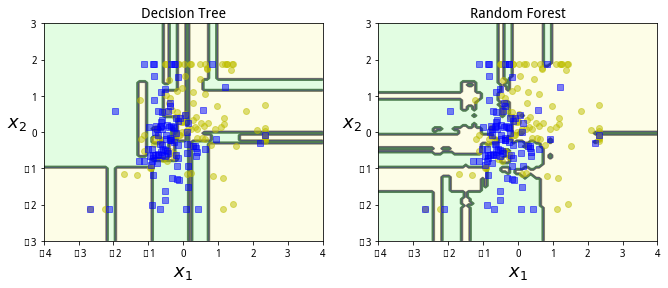

In [187]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-4, 4, -3, 3], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, np.array(predictors), np.array(lables_class))
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(rnd_clf, np.array(predictors), np.array(lables_class))
plt.title("Random Forest", fontsize=14)
plt.show()